# PyTorch AutoEncoder (MNIST)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# 하이퍼파라미터

In [15]:
batch_size = 128
epochs = 20
learning_rate = 1e-3
folder_path = 'result_ipynb'

# MNIST 데이터셋 로드

In [16]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

이미지 shape: torch.Size([128, 1, 28, 28])
라벨 shape: torch.Size([128])
첫 번째 이미지 라벨: 2


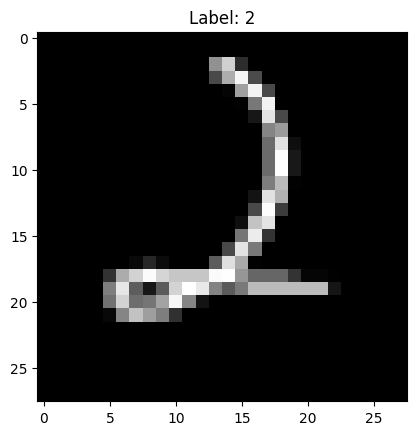

이미지 shape: torch.Size([128, 1, 28, 28])
라벨 shape: torch.Size([128])
첫 번째 이미지 라벨: 7


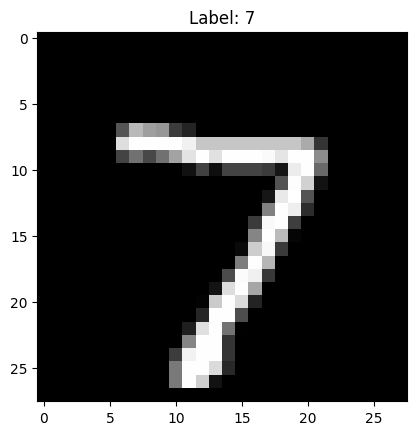

In [32]:
# train_loader에서 배치 하나 보기
for images, labels in train_loader:
    print("이미지 shape:", images.shape)  # (batch_size, 1, 28, 28)
    print("라벨 shape:", labels.shape)    # (batch_size,)
    print("첫 번째 이미지 라벨:", labels[0].item())
    # 예시로 첫 번째 이미지를 시각화
    import matplotlib.pyplot as plt
    plt.imshow(images[0].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[0].item()}")
    plt.show()
    break  # 첫 배치만 보고 종료

# test_loader도 동일하게 사용 가능
for images, labels in test_loader:
    print("이미지 shape:", images.shape)
    print("라벨 shape:", labels.shape)
    print("첫 번째 이미지 라벨:", labels[0].item())
    plt.imshow(images[0].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[0].item()}")
    plt.show()
    break

# AutoEncoder 모델 정의

In [25]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 12),
            nn.GELU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return encoded, decoded

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 루프

In [18]:
model.train()
for epoch in range(1, epochs+1):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')
# 학습 종료 후 가중치 저장
weight_path = os.path.join(folder_path, "weight")
if not os.path.exists(weight_path):
    os.makedirs(weight_path)
torch.save(model.state_dict(), os.path.join(weight_path, 'autoencoder_weights.pth'))

Epoch [1/20], Loss: 0.0668
Epoch [2/20], Loss: 0.0468
Epoch [3/20], Loss: 0.0420
Epoch [4/20], Loss: 0.0397
Epoch [5/20], Loss: 0.0382
Epoch [6/20], Loss: 0.0372
Epoch [7/20], Loss: 0.0364
Epoch [8/20], Loss: 0.0357
Epoch [9/20], Loss: 0.0352
Epoch [10/20], Loss: 0.0347
Epoch [11/20], Loss: 0.0343
Epoch [12/20], Loss: 0.0340
Epoch [13/20], Loss: 0.0336
Epoch [14/20], Loss: 0.0334
Epoch [15/20], Loss: 0.0331
Epoch [16/20], Loss: 0.0329
Epoch [17/20], Loss: 0.0327
Epoch [18/20], Loss: 0.0325
Epoch [19/20], Loss: 0.0323
Epoch [20/20], Loss: 0.0322


# 저장된 가중치 불러오기

In [28]:
weight_path = os.path.join(folder_path, "weight", "autoencoder_weights.pth")
model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

# 테스트 및 결과 시각화

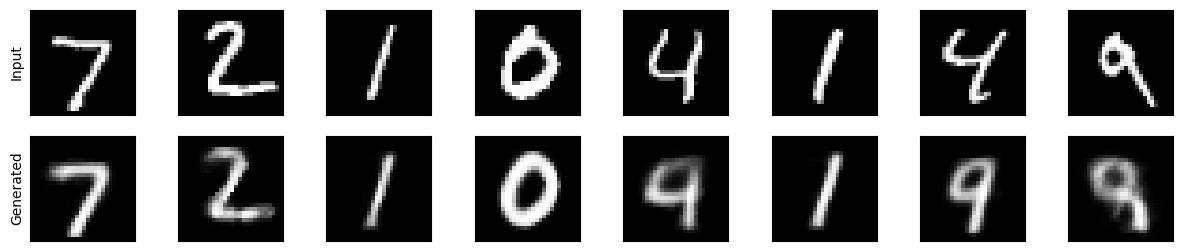

In [47]:
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        _, outputs = model(images)
        break  # 첫 배치만 시각화
images = images.cpu().numpy()
outputs = outputs.cpu().numpy()

# result 폴더 생성
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
fig, axes = plt.subplots(2, 8, figsize=(15, 3))
for i in range(8):
    axes[0, i].imshow(images[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
axes[0, 0].set_ylabel('Input')
axes[1, 0].set_ylabel('Generated')
plt.show()

# Test the autoencoder and plot the latent space

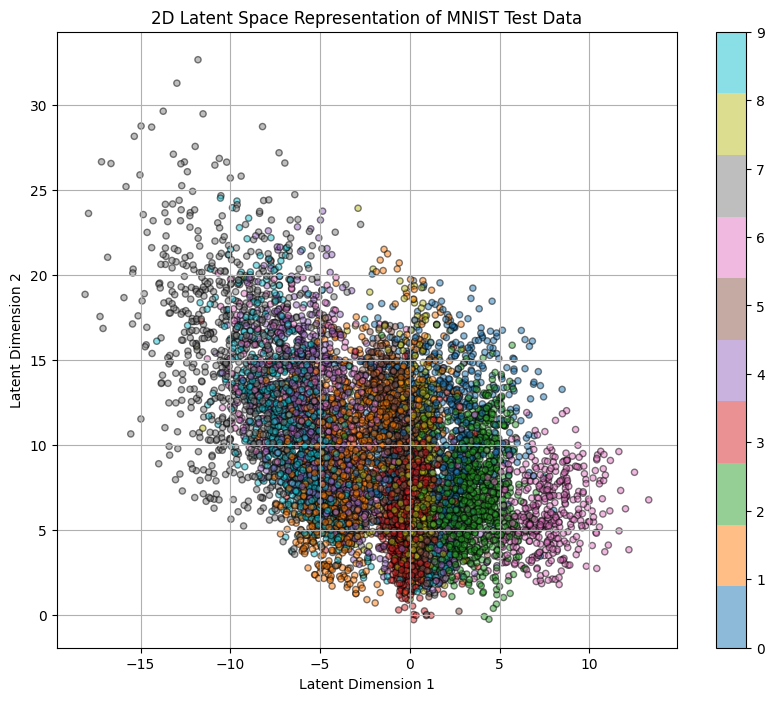

In [30]:
model.eval()
all_encoded = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.view(-1, 784).to(device)  # Move inputs to the same device as the model
        encoded, _ = model(inputs)
        all_encoded.append(encoded.cpu())
        all_labels.append(labels.cpu())

# Concatenate all the encoded outputs and labels
all_encoded = torch.cat(all_encoded)
all_labels = torch.cat(all_labels)

# Plot the 2D latent space with clearer distinctions between clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(all_encoded[:, 0], all_encoded[:, 1], c=all_labels, cmap='tab10', alpha=0.5, edgecolors='k', s=20)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Representation of MNIST Test Data')
plt.grid(True)
plt.show()
